# Analyse et classification de posts Reddit provenant de Subreddit sur l'autisme

- Configuration & import

In [71]:
# Import librairies needed for this project
import warnings
warnings.filterwarnings("ignore")

from sqlalchemy import create_engine
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

import gc

import nltk
nltk.download("stopwords")
from utils.nlp_utils_autism import normalize_corpus, plot_top_words
from sklearn.feature_extraction.text import  TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

import mlflow
import os
from dotenv import load_dotenv

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
load_dotenv()

True

## 1) Nettoyage

Les données utilisées sont stockées dans une base de données PostgreSQL. On va donc se connecter à la table de la base de données en utilisant SQLAlchemy et Psycopg2. Une fois la connexion établie, on pourra utiliser Pandas pour mettre nos données dans un dataFrame.

In [73]:
STRING_CONNECTION = os.getenv('string_connection')
engine = create_engine(STRING_CONNECTION)

In [74]:
df = pd.read_sql("reddit_extraction", 
                 con=engine)
df.head()

,index,title,score,id,url,num_comments,text,subreddit_name
0,2,"Dear *those* autistic men,",345,13h5ymk,https://www.reddit.com/r/autism/comments/13h5y...,123,Our lives aren't automatically better then you...,Autism
1,3,You only accept it as long as it doesn’t incon...,1085,13gyesp,https://i.redd.it/doeb5enynqza1.jpg,48,None,Autism
2,4,Yeah basically.,434,13gxkud,https://i.redd.it/vkm7vfz1hqza1.jpg,8,None,Autism
3,5,"""i feel like neurotypical people actually enjo...",807,13gsoty,https://i.redd.it/yc7a52r8ynza1.png,37,None,Autism
4,6,"Or, if I have different colors, I have to eat ...",425,13gxlkt,https://i.redd.it/lai29qz7hqza1.jpg,16,None,Autism


On va supprimer les posts doublons en se basant sur la colonne "id" qui contient un identifiant unique pour chaque post. On va ensuite supprimer les valeurs manquantes.

In [75]:
df.drop_duplicates('id',
                   inplace=True)

In [76]:
df.dropna(inplace=True, 
          how="any")
df.shape

(16696, 8)

## 2) Analyse de données

L'analyse de données sera divisée en deux grandes parties :
- une partie sur les données chiffrées. Elles sont peu nombreuses mais peuvent permettre de définir des critères d'exclusion de posts si besoin.
- une partie sur les données textuelles. Cette analyse nous permettra d'avoir une idée du contenu des posts mais aussi de voir les mots qui peuvent être considérés comme des stopwords dans notre cas spécifiques.

### a) Analyse quantitative

L'analyse quantitative contient une analyse univariée du score et du nombre de réponses sur chaque post. Ensuite, une analyse bivariée portant sur la corrélation entre le score et le nombre de réponse a été réalisé. 
Ces différentes analyses permettent de définir le profil d'un post moyen avec son nombre moyen et médian de commentaires et de son score.

#### Analyse univariée

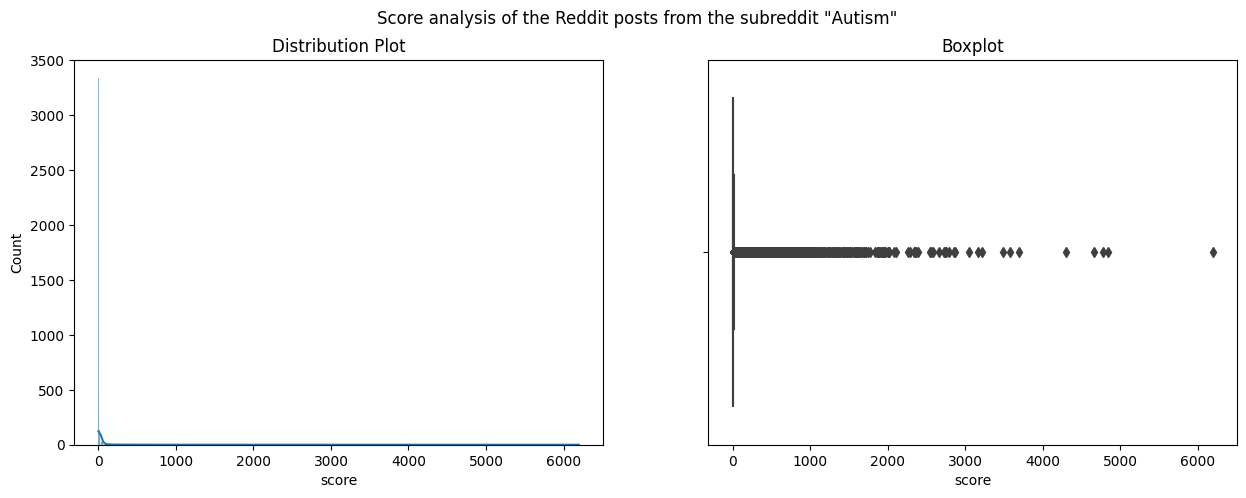

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Score analysis of the Reddit posts from the subreddit "Autism"')

sns.histplot(ax=axes[0], x="score", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="score", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [78]:
print("Mean score:", (np.mean(df["score"])).round(2))
print("Median score:", np.median(df["score"]))

Mean score: 44.22
Median score: 3.0


Le score médian est de 3 alors que le score moyen est de 41.73. 

On observe une grande différence entre le score moyen et le score médian. Si on choisit le score comme critère d'exclusion, il serait donc intéressant de conserver les posts avec un score minimum de 3. 

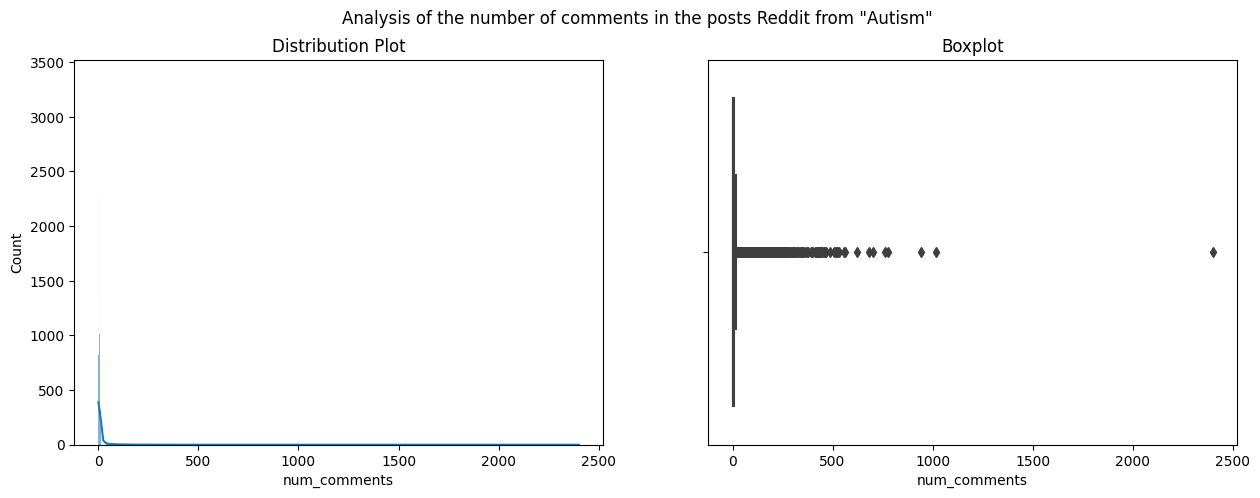

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Analysis of the number of comments in the posts Reddit from "Autism"')

sns.histplot(ax=axes[0], x="num_comments", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="num_comments", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [80]:
print("Mean number of comments: ", (np.mean(df["num_comments"]).round(2)))
print("Median number of comments: ", np.median(df["num_comments"]))

Mean number of comments:  13.62
Median number of comments:  3.0


Le nombre de réponse médian est de 3 alors que le nombre de réponse moyen est de 12.37.

Comme pour le score, le nombre de réponse médian et le nombre de réponse moyen présente un grand écart. Il serait donc intéressant de conserver les posts avec un nombre de réponse égale ou supérieur à 3.

#### Analyse bivariée

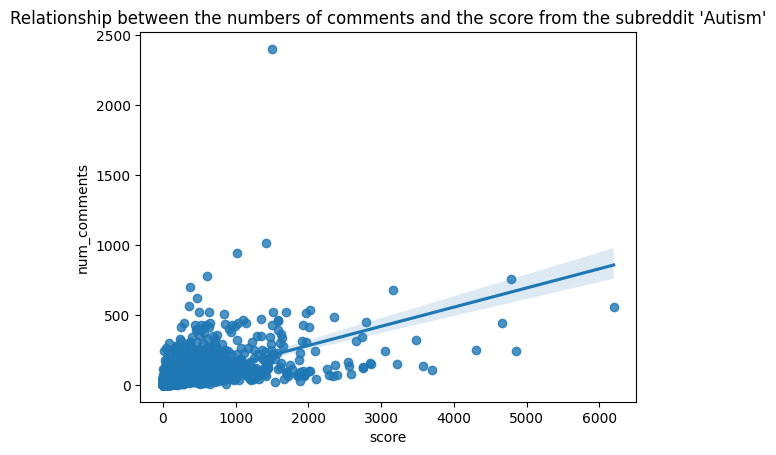

In [81]:
sns.regplot(x="score",
            y="num_comments",
            data=df)
plt.title("Relationship between the numbers of comments and the score from the subreddit 'Autism'")
plt.show()

In [82]:
print("Correlation coefficient:", round(np.corrcoef(df["num_comments"], df["score"])[0,1], 3))

Correlation coefficient: 0.629


- Suppression des posts

In [83]:
ind = df.loc[(df["num_comments"] <= 3) | (df["score"] <= 3)].index.to_list()
df.drop(index = ind, 
        inplace = True)

In [84]:
df.shape

(5386, 8)

### b) Analyse textuelle

#### Analyse du contenu des titres

In [85]:
df_title = df[["id","title"]]
df_title.head()

,id,title
0,13h5ymk,"Dear *those* autistic men,"
6,13h6s7n,I am a server. I waited on someone with autism...
9,13h3wzn,DJing has been a great way for me to share one...
10,13gpg1j,It makes me extremely angry that we don’t have...
12,13gypoa,Does anyone else mask even when they're alone?


In [86]:
df_title["title_norm"] = normalize_corpus(df_title["title"])
df_title.head()

,id,title,title_norm
0,13h5ymk,"Dear *those* autistic men,",dear man
6,13h6s7n,I am a server. I waited on someone with autism...,I server I wait stop
9,13h3wzn,DJing has been a great way for me to share one...,djing great I share special interest stim freely
10,13gpg1j,It makes me extremely angry that we don’t have...,I extremely angry male sa statistic
12,13gypoa,Does anyone else mask even when they're alone?,mask alone


In [87]:
vectorizer_tf = TfidfVectorizer()

tfidf_title = vectorizer_tf.fit_transform(df_title['title_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.mean(), columns=["Value"])
df_title_tf = df_title_tf.sort_values("Value",ascending=False)
df_title_tf = df_title_tf.head(30)
df_title_tf = df_title_tf.sort_values("Value", ascending=True)

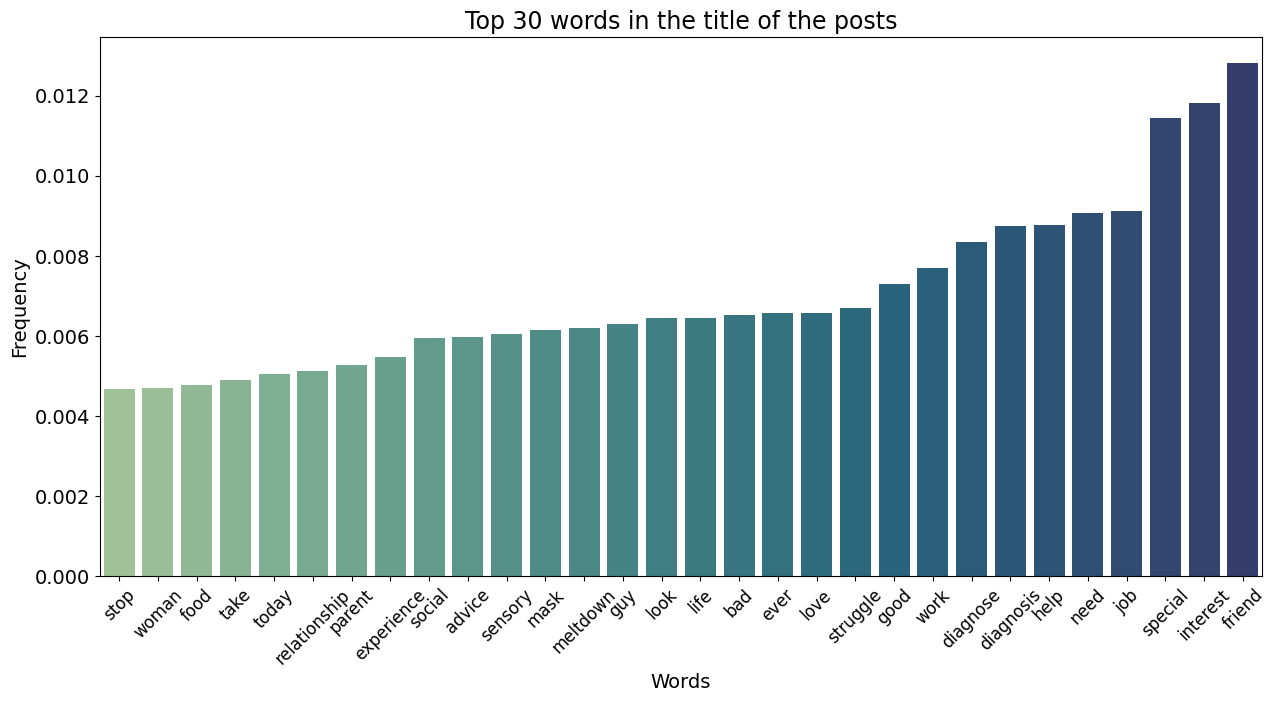

In [88]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_title_tf.index,
    y = df_title_tf["Value"],
    data = df_title_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the title of the posts", fontsize = 17)

plt.show()

#### Analyse du contenu des posts

In [89]:
df_text = df[["id","text"]]

In [90]:
df_text["text_norm"] = normalize_corpus(df_text["text"])
df_text.head()

,id,text,text_norm
0,13h5ymk,Our lives aren't automatically better then you...,life automatically well stuggle girlfriend stu...
6,13h6s7n,I (20M) work at a popular soul food chain in t...,I work popular soul food chain southeast part ...
9,13h3wzn,I have been DJing for about 5 years and am now...,I dj year gig I actually enjoy I share small v...
10,13gpg1j,9/10 Afab autistic people get SAed in their li...,afab saed lifetime I attempt amab statistic si...
12,13gypoa,I'm constantly imagining that someone is watch...,I constantly imagine watch I I pay lot attenti...


In [91]:
vectorizer_tf = TfidfVectorizer()
tfidf_text = vectorizer_tf.fit_transform(df_text['text_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_text_tf = pd.DataFrame(tfidf_text, columns=feature_names)
df_text_tf = pd.DataFrame(df_text_tf.mean(), columns=["Value"])
df_text_tf = df_text_tf.sort_values("Value",ascending=False)
df_text_tf = df_text_tf.head(30)
df_text_tf = df_text_tf.sort_values("Value", ascending = True)

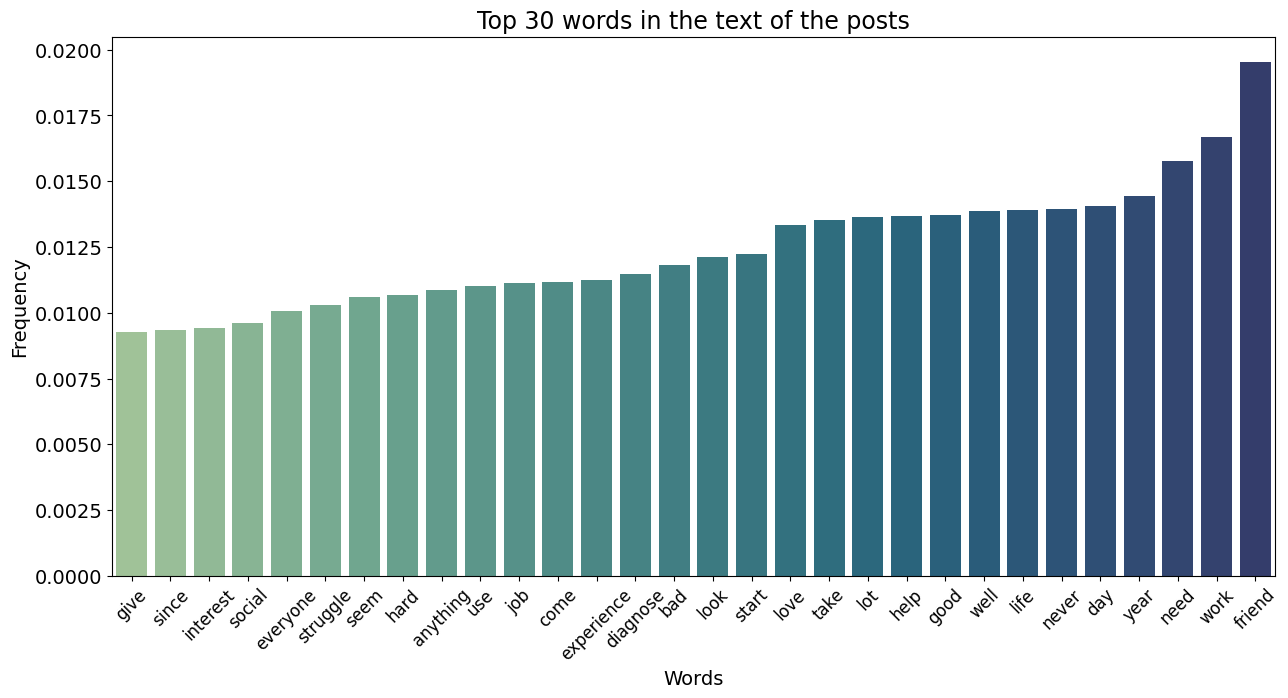

In [92]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_text_tf.index,
    y = df_text_tf["Value"],
    data = df_text_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the text of the posts", fontsize = 17)

plt.show()

## 3) Topic modeling

- Prépartion des données

In [93]:
docs = df_title["title_norm"] + " " + df_text["text_norm"]

In [94]:
docs = docs.values.astype('U')

In [95]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [96]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.274 %


- Modélisation via NMF

In [97]:
dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

In [98]:
topic_nums = list(np.arange(5, 10 + 1, 1))
coherence_scores = []

In [99]:
for num in topic_nums:
    nmf = Nmf(
        corpus = corpus,
        num_topics = num, 
        id2word=common_dictionary,
        chunksize = 2000,
        normalize = True,
        random_state = 42
    )

    cm = CoherenceModel(
        model = nmf,
        texts = dataset,
        dictionary=common_dictionary,
        coherence = 'c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

In [100]:
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

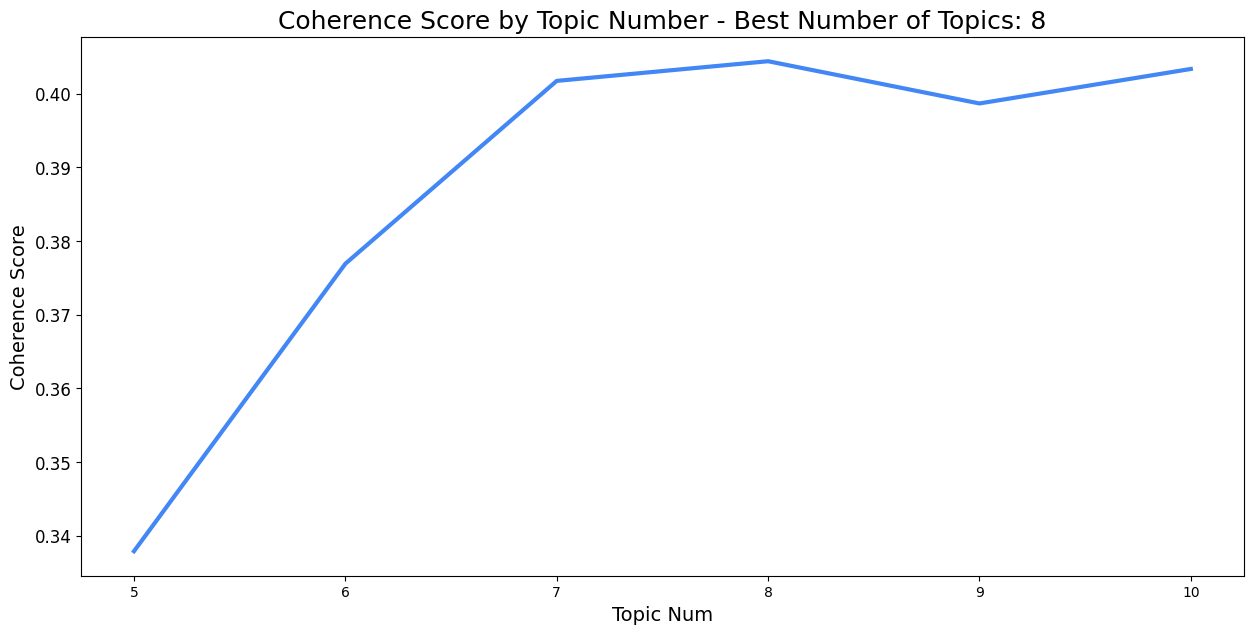

In [101]:
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth = 3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.yticks(fontsize=12)

plt.show()

In [102]:
nmf = NMF(n_components = 8,
          random_state = 42)
nmf.fit(tfidf)

2023/08/04 18:29:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cb397aef52874b80bf302e8c9d2e9f66', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/04 18:29:20 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/08/04 18:29:20 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/08/04 18:29:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


NMF(n_components=8, random_state=42)

- Visualisation du résultat

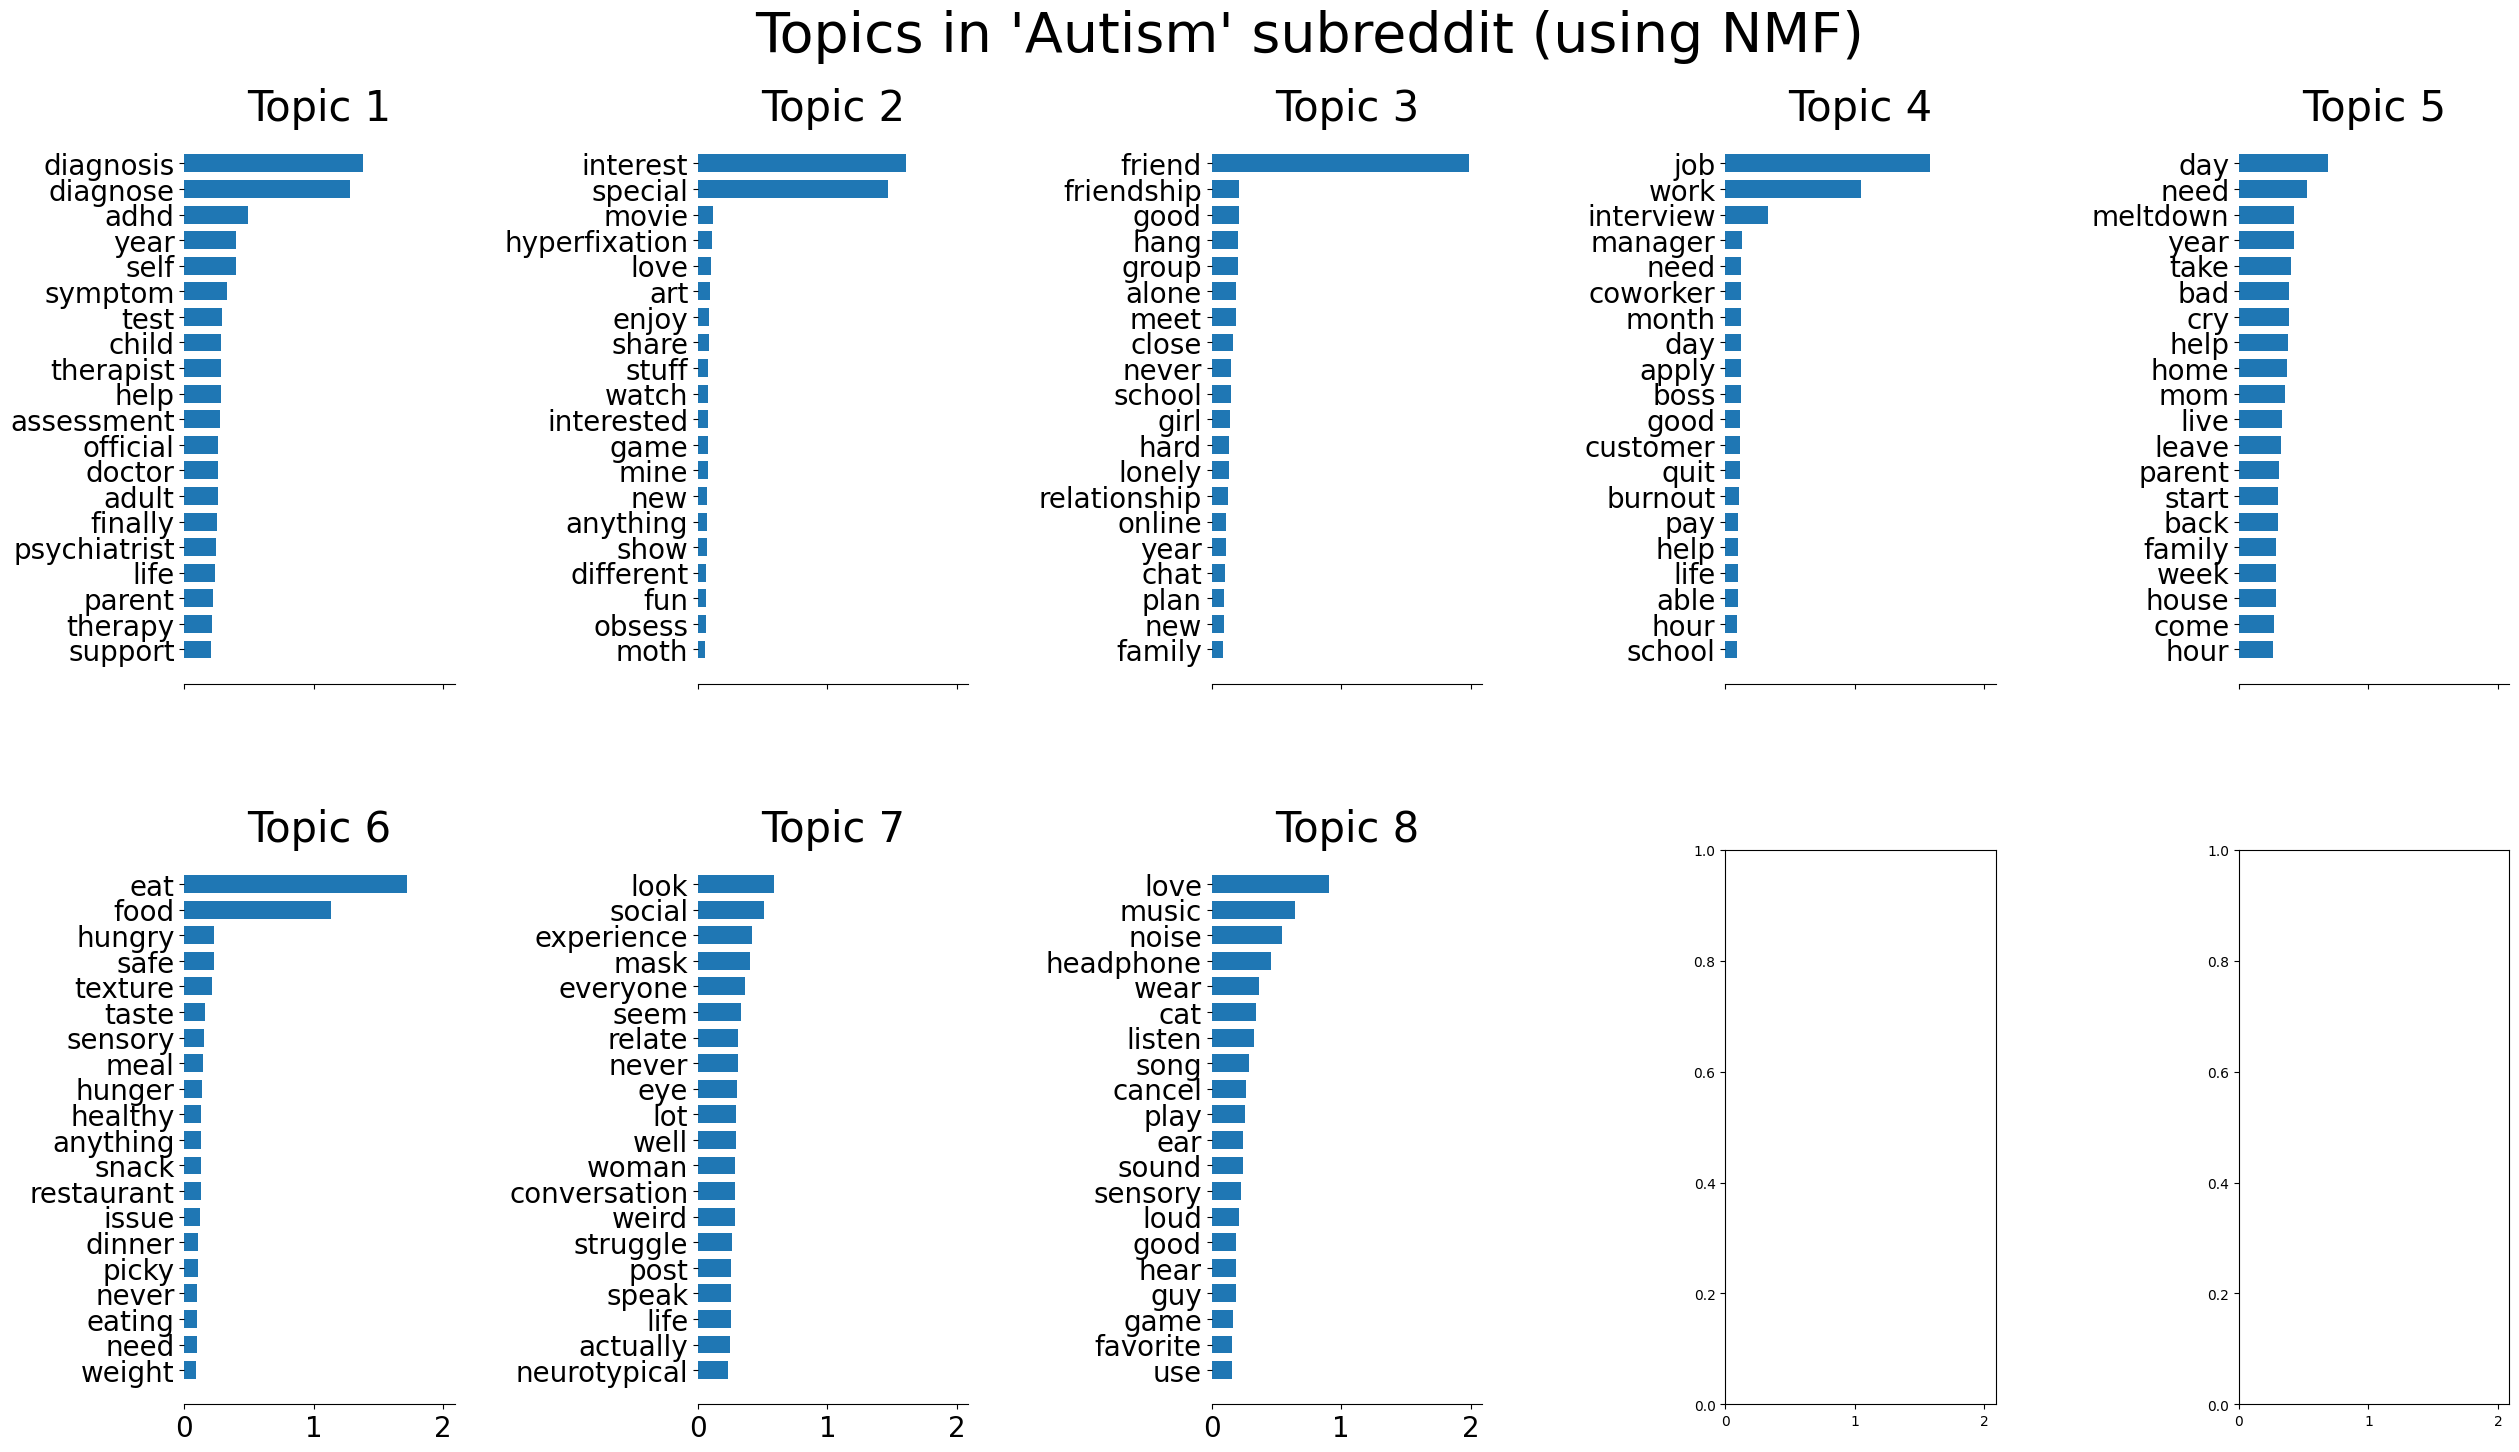

In [103]:
plot_top_words(nmf, 
               tfidf_feature_names, 
               n_top_words = 20, 
               title = "Topics in 'Autism' subreddit (using NMF)")

- Topic 1 : Health
- Topic 2 : Special Interests
- Topic 3 : Relationship
- Topic 4 : Work
- Topic 5 : Daily Life
- Topic 6 : Food
- Topic 7 : Social interaction
- Topic 8 : Noise

## 4) Etiquettage des données

In [104]:
df["title_&_text_norm"] = df_title["title_norm"] + " " + df_text["text_norm"]

In [105]:
df.head()

,index,title,score,id,url,num_comments,text,subreddit_name,title_&_text_norm
0,2,"Dear *those* autistic men,",345,13h5ymk,https://www.reddit.com/r/autism/comments/13h5y...,123,Our lives aren't automatically better then you...,Autism,dear man life automatically well stuggle girlf...
6,8,I am a server. I waited on someone with autism...,34,13h6s7n,https://www.reddit.com/r/autism/comments/13h6s...,5,I (20M) work at a popular soul food chain in t...,Autism,I server I wait stop I work popular soul food ...
9,11,DJing has been a great way for me to share one...,40,13h3wzn,https://v.redd.it/h34jtui61sza1,6,I have been DJing for about 5 years and am now...,Autism,djing great I share special interest stim free...
10,12,It makes me extremely angry that we don’t have...,219,13gpg1j,https://www.reddit.com/r/autism/comments/13gpg...,47,9/10 Afab autistic people get SAed in their li...,Autism,I extremely angry male sa statistic afab saed ...
12,14,Does anyone else mask even when they're alone?,47,13gypoa,https://www.reddit.com/r/autism/comments/13gyp...,9,I'm constantly imagining that someone is watch...,Autism,mask alone I constantly imagine watch I I pay ...


In [106]:
def topic_table(n_top_words, feature_names, nmf):
  topics = {}
  for i, topic_vec in enumerate(nmf.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr
  return pd.DataFrame({'Top_Topic_Terms': topics})

In [107]:
topic_df = topic_table(5, tfidf_vectorizer.get_feature_names_out(), nmf)

topic_df['Label'] = ['Health', 'Special Interests', 
                     'Relationship', 'Work',
                     'Daily Life', 'Food',
                     'Social interaction', 'Noise']
document_weights = nmf.transform(tfidf_vectorizer.transform(df['title_&_text_norm'].astype('U')))

df["Topic_Number"] = document_weights.argmax(axis=1)
df = pd.merge(df, 
              topic_df, 
              left_on='Topic_Number', 
              right_index=True, 
              how='left')

## 5) Classification des posts

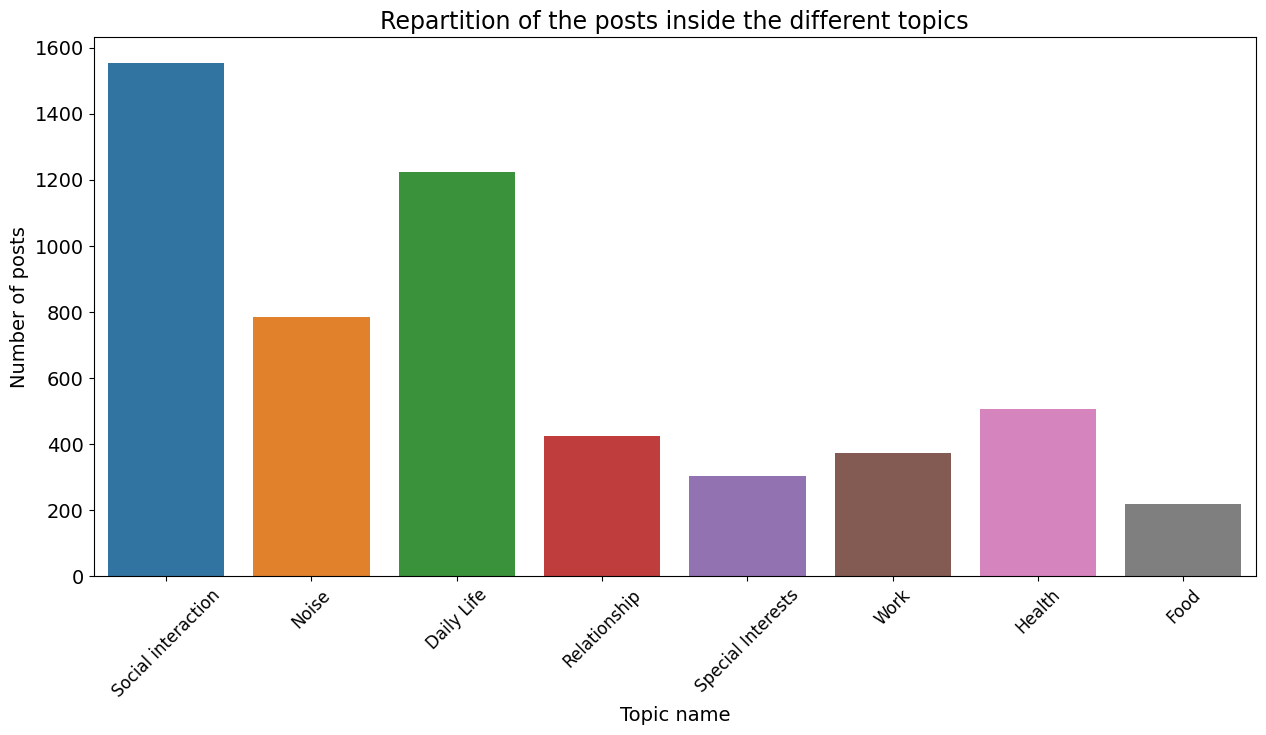

In [108]:
fig = plt.figure(figsize=(15, 7))

g = sns.countplot(x = "Label",
              data = df)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12)


plt.yticks(fontsize = 14)
plt.xlabel("Topic name",
            fontsize = 14)
plt.ylabel("Number of posts",
           fontsize = 14)
plt.title("Repartition of the posts inside the different topics",
          fontsize = 17)

plt.show()

In [109]:
df.drop(["id", "title", "text", 
         "Top_Topic_Terms", "score",
         "url", "num_comments",
         "subreddit_name", "index"], 
        axis = 1,
        inplace=True)

In [110]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, 
                                     test_size=0.25, 
                                     random_state=42)

y_train = train_set[["Topic_Number"]]
y_test = test_set[["Topic_Number"]]
X_train = train_set.drop(["Label","Topic_Number"], axis = 1)
X_test = test_set.drop(["Label","Topic_Number"], axis = 1)

In [111]:
print(len(X_train),
len(X_test))

4039 1347


In [112]:
print(X_train.head())

                                       title_&_text_norm
16855  discord server adult hi due recent protest I d...
25286                               scuse I I sleep hot 
25139  shower flipflop life change discovery I I brea...
11389  might besides general anxiety investigate medi...
21458  thank I post little ago help overstimulation I...


In [113]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("reddit-classifier")

<Experiment: artifact_location='/home/cecile/Documents/Reddit-Analysis/reddit-nlp-analysis/mlruns/1', creation_time=1689889333362, experiment_id='1', last_update_time=1689889333362, lifecycle_stage='active', name='reddit-classifier', tags={}>

In [114]:
mlflow.sklearn.autolog()

with mlflow.start_run():
    mlflow.set_tag("developper", "cecile")
    tfidf = TfidfVectorizer()
    tfidf.fit(X_train['title_&_text_norm'].astype('U'))
    X_train_vec = tfidf.transform(X_train['title_&_text_norm'].astype('U'))
    n_estimators = 200
    mlflow.log_param("n_estimators", n_estimators)
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                random_state=42)
    rf.fit(X_train_vec, y_train)

    X_test_vec = tfidf.transform(X_test['title_&_text_norm'].astype('U'))
    y_pred = rf.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

2023/08/04 18:29:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'toarray'
2023/08/04 18:29:43 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: too many indices for array: array is 2-dimensional, but 3 were indexed


In [115]:
print("Accuracy Score: ", round(accuracy, 5) * 100, "%")

Accuracy Score:  76.837 %


(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

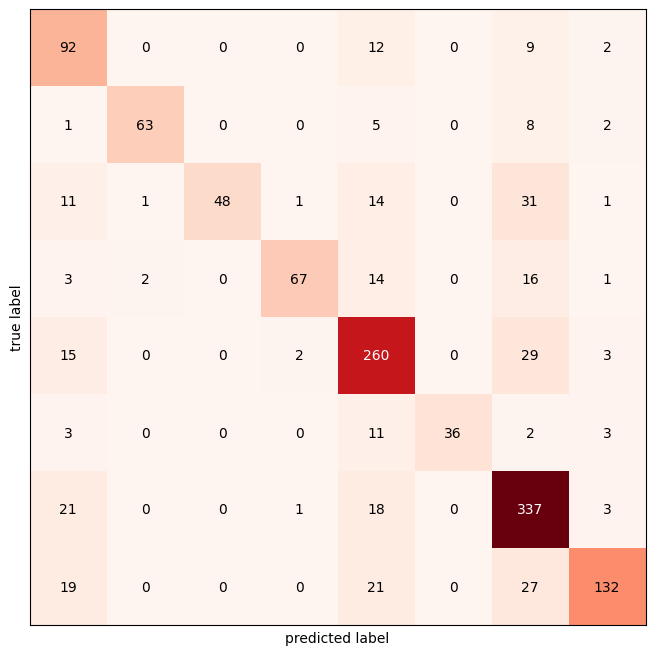

In [116]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test,
                      y_pred)
plot_confusion_matrix(cm,
                      figsize = (12,8), 
                      hide_ticks = True,
                      cmap=plt.cm.Reds)

## Test du modèle mise en production

In [117]:
import json
from json import JSONEncoder
import requests

In [118]:
test_post = normalize_corpus("""I think I hate advertising way more than average
blood boiling whenever i see it on TV. i was watching baseball last night on normal TV [instead of the internet which blocks the ads] and didn't have the remote -- so i just had 2-3 mins of ads blaring out. loud music, annoying people, bright colors -- all to push some dipshit, pointless piece of shit products that don't need to exist
and i believe some people just experience life like this!! some people don't care about ads and don't mute them! some people let this horseshit blare out into their home!!
insane
""")

In [119]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
numpyData = {"dataframe_records": test_post}
json_test = json.dumps(numpyData, cls=NumpyArrayEncoder)

In [120]:
host = '0.0.0.0'
port = '8001'

url = f'http://{host}:{port}/invocations'

headers = {
    'Content-Type': 'application/json',
}

r = requests.post(url=url, headers=headers, data=json_test)
pred = str(r.text)

if('0' in pred): 
    print("Predictions: Daily Life")
elif ('1' in pred):
    print("Predictions: Friendship")
elif('2' in pred):
    print("Predictions: Special Interests")
elif('3' in pred):
    print("Predictions: Health")
elif('4' in pred):
    print("Predictions: Work")
elif('5' in pred):
    print('Predictions: Food')
elif('6' in pred):
    print('Predictions: Social Interaction')
elif('7' in pred):
    print('Predictions: Noise')
else:
    print("Topic not found")

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8001): Max retries exceeded with url: /invocations (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6d51b2ce80>: Failed to establish a new connection: [Errno 111] Connection refused'))